<a href="https://colab.research.google.com/github/LillisLuo/CV-Project/blob/main/CV_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import torch.nn as nn
import torch

from torch import Tensor
from typing import Type

In [84]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Concatenate, MaxPool2D, GlobalAveragePooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import tensorflow as tf

In [76]:
!pip install tflocalpattern
from tflocalpattern.layers import LDP

(1867, 62, 47, 3)


<ipython-input-105-13a6ebb47bd7>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_rgb_images = [Image.fromarray(image).resize((224, 224), Image.ANTIALIAS) for image in normalized_images]


(1867, 224, 224, 3)
RGB Scale Images


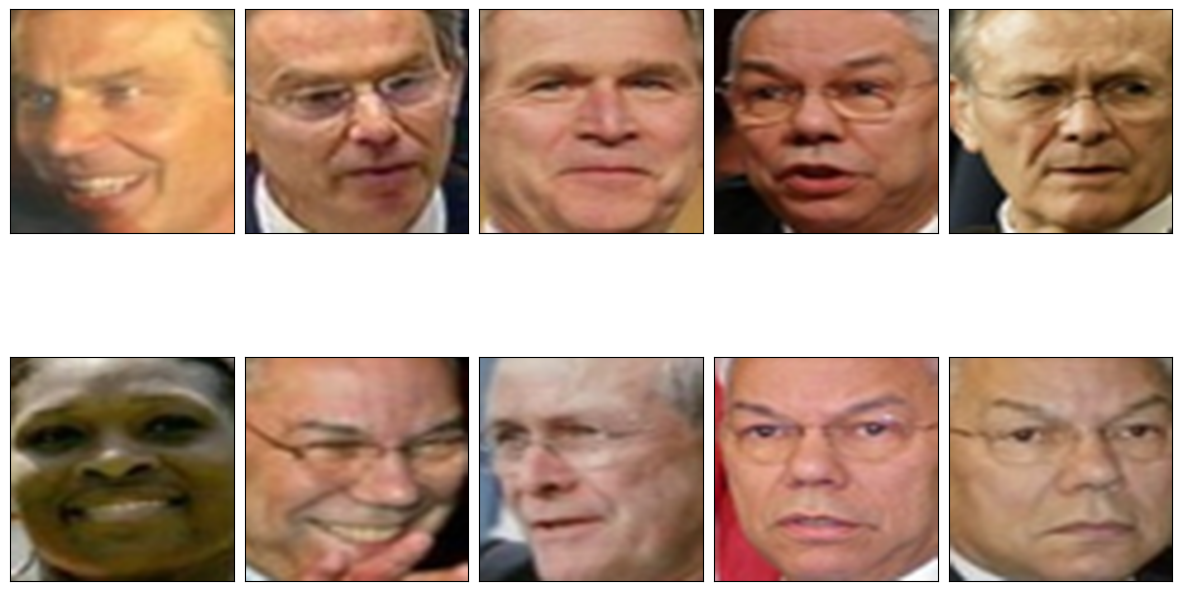

In [105]:
from PIL import Image
import numpy as np
# lfw_people_grayscale = fetch_lfw_people(min_faces_per_person=40, resize=0.5)
lfw_people_rgb = fetch_lfw_people(min_faces_per_person=40, resize=0.5, color=True)

# Original images
# grayscale_images = lfw_people_grayscale.images
rgb_images = lfw_people_rgb.images
print(rgb_images.shape)

normalized_images = np.array([np.uint8(image * 255) for image in rgb_images])

# Resize images to 224x224
resized_rgb_images = [Image.fromarray(image).resize((224, 224), Image.ANTIALIAS) for image in normalized_images]

# Convert back to numpy arrays
resized_images = np.array([np.asarray(image) for image in resized_rgb_images])

# print(grayscale_images.shape)
print(resized_images.shape)

print("RGB Scale Images")
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.3, wspace=0.05))
for i, ax in enumerate(axes.flat):
    ax.imshow(resized_images[i])

plt.show()


In [106]:
# training parameters
batch_size = 64
epochs     = 100
lrate      = 2e-4

X = resized_images
y = lfw_people_rgb.target
nclasses = lfw_people_rgb.target_names.shape[0]

print("The number of classess: ",nclasses)

# Split dataset into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    stratify=y,
                                                    random_state=42)

x_train = x_train.astype('float32')/255.0
x_test  = x_test.astype( 'float32')/255.0

print(x_train.shape)
print(x_test.shape)
y_train = to_categorical(y_train, nclasses)
y_test  = to_categorical(y_test, nclasses)

The number of classess:  19
(1493, 224, 224, 3)
(374, 224, 224, 3)


In [93]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)

        # LDP layers after the first two ResNet blocks
        # self.ldp_1 = LDP(mode='single', alpha='0')
        # self.ldp_2 = LDP(mode='single', alpha='45')
        # self.ldp_3 = LDP(mode='single', alpha='90')
        # self.ldp_4 = LDP(mode='single', alpha='135')

        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)

        # out = self.res_1_1(out)
        # out = self.res_1_2(out)

        # # Applying LDP layers
        # out_ldp1 = self.ldp_1(out)
        # out_ldp2 = self.ldp_2(out)
        # out_ldp3 = self.ldp_3(out)
        # out_ldp4 = self.ldp_4(out)
        # out = layers.Concatenate()([out, out_ldp1, out_ldp2, out_ldp3, out_ldp4])

        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)

        # for res_block in [self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
        #     out = res_block(out)

        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

class ResNet18WithLDP(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)

        # LDP layers after the first two ResNet blocks
        self.ldp_1 = LDP(mode='single', alpha='0')
        self.ldp_2 = LDP(mode='single', alpha='45')
        self.ldp_3 = LDP(mode='single', alpha='90')
        self.ldp_4 = LDP(mode='single', alpha='135')

        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)

        out = self.res_1_1(out)
        out = self.res_1_2(out)

        # # Applying LDP layers
        out_ldp1 = self.ldp_1(out)
        out_ldp2 = self.ldp_2(out)
        out_ldp3 = self.ldp_3(out)
        out_ldp4 = self.ldp_4(out)
        out = layers.Concatenate()([out, out_ldp1, out_ldp2, out_ldp3, out_ldp4])

        # for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
        #     out = res_block(out)

        for res_block in [self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)

        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [94]:
checkpoint_filepath2 = './checkpoints/checkpoint2.ckpt'
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

model_base = ResNet18(nclasses)
model_base.build(input_shape=(None,224,224,3))
from keras.optimizers import SGD
model_base.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["acc"])
model_base.summary()

history2 = model_base.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint_callback2],
                    validation_split=0.2,
                    verbose=False)

model_base.load_weights(checkpoint_filepath2)

test_loss2,test_acc2=model_base.evaluate(x_test,y_test)
print('test acc for model_base: ', test_acc2)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1512 (Conv2D)        multiple                  9472      
                                                                 
 batch_normalization_643 (B  multiple                  256       
 atchNormalization)                                              
                                                                 
 max_pooling2d_41 (MaxPooli  multiple                  0         
 ng2D)                                                           
                                                                 
 resnet_block_192 (ResnetBl  multiple                  74368     
 ock)                                                            
                                                 

In [95]:
checkpoint_filepath1 = './checkpoints/checkpoint1.ckpt'
model_checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

model_ldp = ResNet18WithLDP(nclasses)
model_ldp.build(input_shape=(None,224,224,3))
from keras.optimizers import SGD
model_ldp.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["acc"])
model_ldp.summary()

history1 = model_ldp.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint_callback1],
                    validation_split=0.2,
                    verbose=False)

model_ldp.load_weights(checkpoint_filepath1)

test_loss1,test_acc1=model_ldp.evaluate(x_test,y_test)
print('test acc for model_base: ', test_acc1)

Model: "res_net18_with_ldp_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1532 (Conv2D)        multiple                  9472      
                                                                 
 batch_normalization_663 (B  multiple                  256       
 atchNormalization)                                              
                                                                 
 max_pooling2d_42 (MaxPooli  multiple                  0         
 ng2D)                                                           
                                                                 
 resnet_block_200 (ResnetBl  multiple                  74368     
 ock)                                                            
                                                                 
 resnet_block_201 (ResnetBl  multiple                  74368     
 ock)                                        

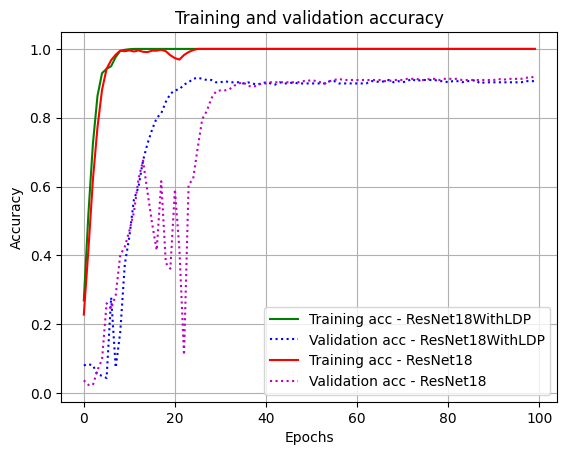

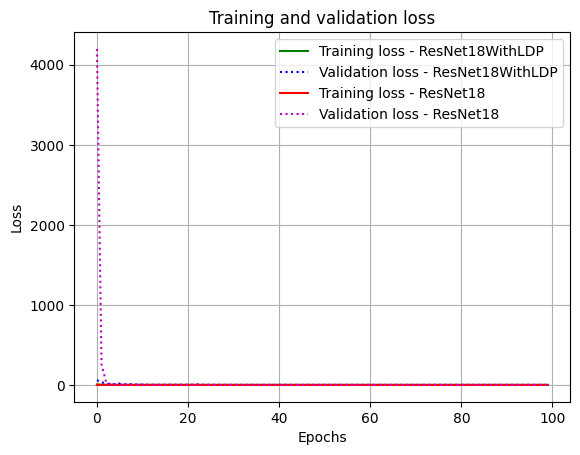

In [96]:
acc1      = history1.history['acc']
val_acc1  = history1.history['val_acc']
loss1     = history1.history['loss']
val_loss1 = history1.history['val_loss']

# model_base
acc2      = history2.history['acc']
val_acc2  = history2.history['val_acc']
loss2     = history2.history['loss']
val_loss2 = history2.history['val_loss']

plt.figure(2)
epochs = range(len(acc1))
plt.plot(epochs, acc1,     'g', label='Training acc - ResNet18WithLDP')
plt.plot(epochs, val_acc1, 'b:',label='Validation acc - ResNet18WithLDP')
plt.plot(epochs, acc2,     'r', label='Training acc - ResNet18')
plt.plot(epochs, val_acc2, 'm:',label='Validation acc - ResNet18')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

plt.figure(3)
plt.plot(epochs, loss1,     'g',  label='Training loss - ResNet18WithLDP')
plt.plot(epochs, val_loss1, 'b:', label='Validation loss - ResNet18WithLDP')
plt.plot(epochs, loss2,     'r',  label='Training loss - ResNet18')
plt.plot(epochs, val_loss2, 'm:', label='Validation loss - ResNet18')
plt.title( 'Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [103]:
class InceptionResnetBlock(Model):
    def __init__(self, channels, scale=1.0, activation='relu', downsample=False, **kwargs):
        super().__init__(**kwargs)

        self.scale = scale
        self.activation = activation
        self.downsample = downsample

        # Branch 1: 1x1 Conv
        self.branch1 = Conv2D(32, (1, 1), padding='same', activation='relu')

        # Branch 2: 1x1 Conv -> 3x3 Conv
        self.branch2_1 = Conv2D(32, (1, 1), padding='same', activation='relu')
        self.branch2_2 = Conv2D(32, (3, 3), padding='same', activation='relu')

        # Branch 3: 1x1 Conv -> 3x3 Conv -> 3x3 Conv
        self.branch3_1 = Conv2D(32, (1, 1), padding='same', activation='relu')
        self.branch3_2 = Conv2D(48, (3, 3), padding='same', activation='relu')
        self.branch3_3 = Conv2D(64, (3, 3), padding='same', activation='relu')

        # The 1x1 conv layer for the shortcut path with appropriate stride for downsampling
        strides = (2, 2) if self.downsample else (1, 1)
        self.res_conv = Conv2D(channels, (1, 1), strides=strides, padding='same', activation=None)
        self.res_bn = BatchNormalization()

        # Merging layers
        self.concat = Concatenate()
        self.conv_linear = Conv2D(channels, (1, 1), padding='same', activation=None)
        self.merge = Add()

    def call(self, inputs, training=False):
        # Branches
        x1 = self.branch1(inputs)
        x2 = self.branch2_2(self.branch2_1(inputs))
        x3 = self.branch3_3(self.branch3_2(self.branch3_1(inputs)))

        # Concatenate branches
        mixed = self.concat([x1, x2, x3])

        # Linear path
        up = self.conv_linear(mixed)

        if self.downsample:
            residual = self.res_conv(inputs)
            residual = self.res_bn(residual)
        else:
            residual = self.res_conv(inputs)
            residual = self.res_bn(residual)

        # This is crucial when downsample is True
        if up.shape[1:3] != residual.shape[1:3]:
            up = tf.image.resize(up, size=residual.shape[1:3], method='nearest')

        # Scale up before adding to residual
        up = self.scale * up
        out = self.merge([up, residual])

        # Apply activation
        if self.activation is not None:
            out = Activation(self.activation)(out)
            # out = tf.nn.relu(out)
        return out

class ResNet18WithInception(Model):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2, padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(3, 3), strides=2, padding="same")

        self.res_1_1 = InceptionResnetBlock(channels=64)
        self.res_1_2 = InceptionResnetBlock(channels=64)
        self.res_2_1 = InceptionResnetBlock(channels=128, downsample=True)
        self.res_2_2 = InceptionResnetBlock(channels=128)
        self.res_3_1 = InceptionResnetBlock(channels=256, downsample=True)
        self.res_3_2 = InceptionResnetBlock(channels=256)
        self.res_4_1 = InceptionResnetBlock(channels=512, downsample=True)
        self.res_4_2 = InceptionResnetBlock(channels=512)

        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)

        # Pass the input through the Inception-ResNet-A blocks
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2,
                          self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)

        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [107]:
checkpoint_filepath3 = './checkpoints/checkpoint3.ckpt'
model_checkpoint_callback3 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath3,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

model_incep = ResNet18WithInception(num_classes=nclasses)
model_incep.build(input_shape=(None,224,224,3))
from keras.optimizers import SGD
model_incep.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["acc"])
model_incep.summary()

history3 = model_incep.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint_callback3],
                    validation_split=0.2,
                    verbose=False)

model_incep.load_weights(checkpoint_filepath3)

test_loss3,test_acc3=model_incep.evaluate(x_test,y_test)
print('test acc for model_base: ', test_acc3)

Model: "res_net18_with_inception_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1747 (Conv2D)        multiple                  9472      
                                                                 
 batch_normalization_710 (B  multiple                  256       
 atchNormalization)                                              
                                                                 
 max_pooling2d_46 (MaxPooli  multiple                  0         
 ng2D)                                                           
                                                                 
 inception_resnet_block_136  multiple                  69744     
  (InceptionResnetBlock)                                         
                                                                 
 inception_resnet_block_137  multiple                  69744     
  (InceptionResnetBlock)                

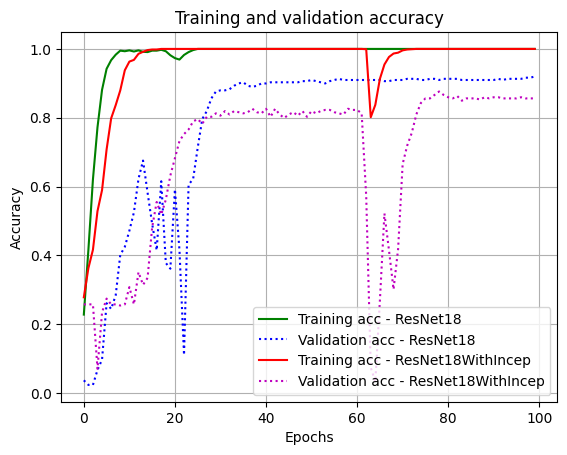

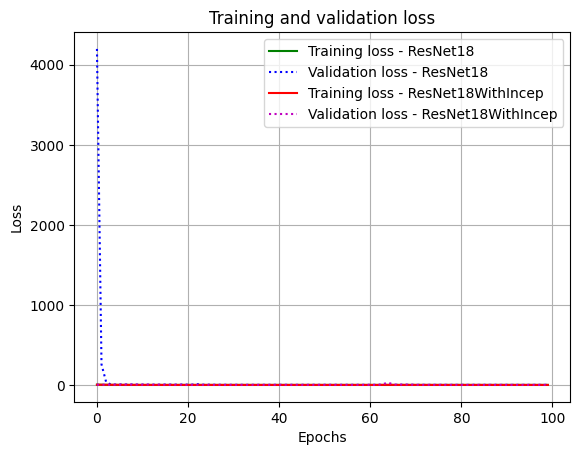

In [108]:
acc2      = history2.history['acc']
val_acc2  = history2.history['val_acc']
loss2     = history2.history['loss']
val_loss2 = history2.history['val_loss']

# model_base
acc3      = history3.history['acc']
val_acc3  = history3.history['val_acc']
loss3     = history3.history['loss']
val_loss3 = history3.history['val_loss']

plt.figure(2)
epochs = range(len(acc2))
plt.plot(epochs, acc2,     'g', label='Training acc - ResNet18')
plt.plot(epochs, val_acc2, 'b:',label='Validation acc - ResNet18')
plt.plot(epochs, acc3,     'r', label='Training acc - ResNet18WithIncep')
plt.plot(epochs, val_acc3, 'm:',label='Validation acc - ResNet18WithIncep')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

plt.figure(3)
plt.plot(epochs, loss2,     'g',  label='Training loss - ResNet18')
plt.plot(epochs, val_loss2, 'b:', label='Validation loss - ResNet18')
plt.plot(epochs, loss3,     'r',  label='Training loss - ResNet18WithIncep')
plt.plot(epochs, val_loss3, 'm:', label='Validation loss - ResNet18WithIncep')
plt.title( 'Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()